[WARN] No mask for: D:\MACS\Semester 2\Digital Image Processing - GACS-7205\Project\Datasets\CASIA2\Tp\Tp_D_CNN_M_N_arc00086_arc00086_00306.tif
[WARN] No mask for: D:\MACS\Semester 2\Digital Image Processing - GACS-7205\Project\Datasets\CASIA2\Tp\Tp_D_CNN_M_N_ind00091_ind00091_10647.jpg
[WARN] No mask for: D:\MACS\Semester 2\Digital Image Processing - GACS-7205\Project\Datasets\CASIA2\Tp\Tp_D_CNN_M_N_ind00091_ind00091_10648.jpg
[WARN] No mask for: D:\MACS\Semester 2\Digital Image Processing - GACS-7205\Project\Datasets\CASIA2\Tp\Tp_D_CNN_M_N_nat00077_nat00077_10574.jpg
[WARN] No mask for: D:\MACS\Semester 2\Digital Image Processing - GACS-7205\Project\Datasets\CASIA2\Tp\Tp_D_CNN_M_N_nat00089_nat00089_10576.jpg
[WARN] No mask for: D:\MACS\Semester 2\Digital Image Processing - GACS-7205\Project\Datasets\CASIA2\Tp\Tp_D_CNN_M_N_nat00090_nat00090_10575.jpg
[WARN] No mask for: D:\MACS\Semester 2\Digital Image Processing - GACS-7205\Project\Datasets\CASIA2\Tp\Tp_D_CNN_M_N_pla00042_pla00042_10

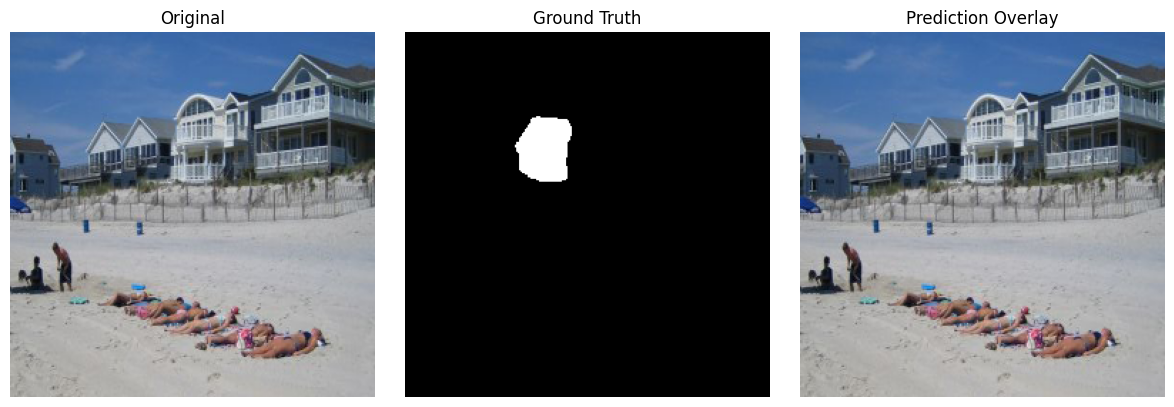

[VIS] Example 571:


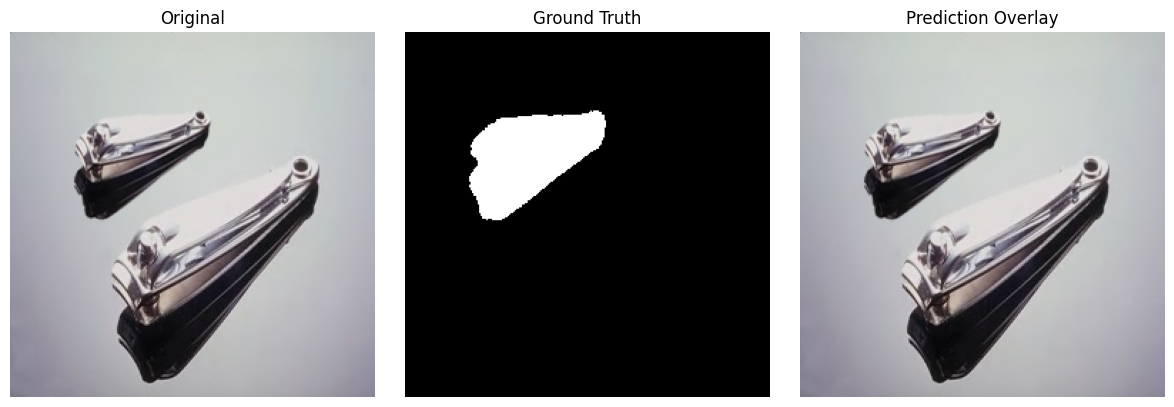

[VIS] Example 513:


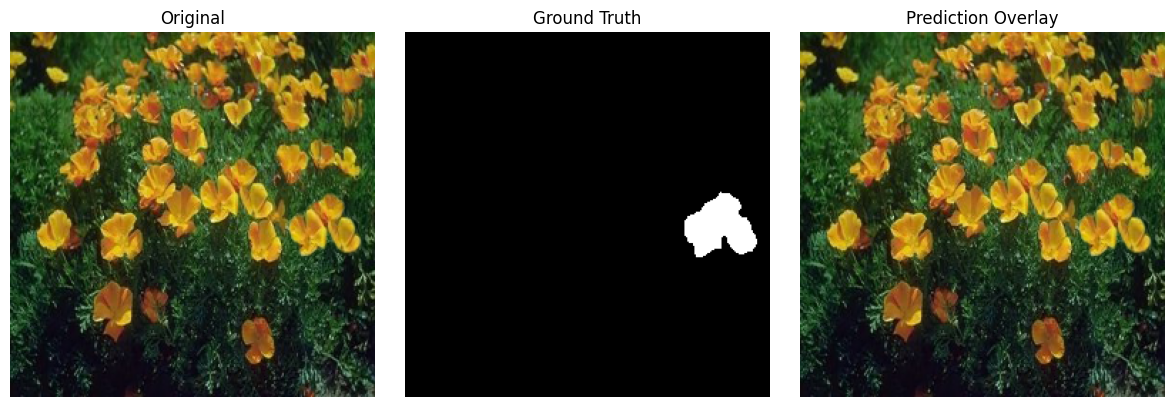

In [2]:
"""
CASIA2 Forgery Segmentation with U-Net + Noise Residual + Histogram Fusion

- Uses only a subset of data:
    40% train, 15% validation, 15% test  (remaining 30% ignored)
- Input to U-Net:
    Channel 0: Red channel of image (normalized)
    Channel 1: SRM-based noise residual
    Channel 2: Histogram inconsistency map
- Output:
    Pixel-wise tampering mask
- Metrics:
    Pixel Accuracy, IoU, Dice, Confusion Matrix
"""

import os
import glob
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras import layers, models

# =========================================================
# 1. CONFIGURATION
# =========================================================

TP_DIR = r"D:\MACS\Semester 2\Digital Image Processing - GACS-7205\Project\Datasets\CASIA2\Tp"
GT_DIR = r"D:\MACS\Semester 2\Digital Image Processing - GACS-7205\Project\Datasets\CASIA2\CASIA 2 Groundtruth"

IMG_SIZE = 256
BATCH_SIZE = 4
EPOCHS = 5          # keep small for speed; you can increase later
RANDOM_STATE = 42

tf.random.set_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

AUTOTUNE = tf.data.AUTOTUNE

# =========================================================
# 2. MATCH CASIA2 Tp IMAGES TO MASKS
# =========================================================

def match_casia2(tp_dir, gt_dir):
    img_exts = ("*.jpg","*.jpeg","*.png","*.bmp","*.tif","*.tiff")
    all_imgs = []
    for e in img_exts:
        all_imgs.extend(glob.glob(os.path.join(tp_dir, e)))

    all_imgs = sorted(all_imgs)
    matched_imgs, matched_masks = [], []

    for img in all_imgs:
        base = os.path.splitext(os.path.basename(img))[0]
        mask_base = base + "_gt"

        found = None
        for ext in [".png",".jpg",".jpeg",".bmp",".tif",".tiff"]:
            mpath = os.path.join(gt_dir, mask_base + ext)
            if os.path.exists(mpath):
                found = mpath
                break

        if found:
            matched_imgs.append(img)
            matched_masks.append(found)
        else:
            print(f"[WARN] No mask for: {img}")

    print(f"[INFO] Total matched Tp+GT pairs: {len(matched_imgs)}")
    return matched_imgs, matched_masks

img_paths_all, mask_paths_all = match_casia2(TP_DIR, GT_DIR)

# =========================================================
# 3. 40 / 15 / 15 SPLIT (REST IGNORED)
# =========================================================

total = len(img_paths_all)
indices = np.arange(total)
np.random.shuffle(indices)

num_train = int(0.40 * total)
num_val   = int(0.15 * total)
num_test  = int(0.15 * total)

train_idx = indices[:num_train]
val_idx   = indices[num_train:num_train+num_val]
test_idx  = indices[num_train+num_val:num_train+num_val+num_test]

def select_by_idx(paths, idx):
    return [paths[i] for i in idx]

train_img = select_by_idx(img_paths_all, train_idx)
train_mask = select_by_idx(mask_paths_all, train_idx)

val_img = select_by_idx(img_paths_all, val_idx)
val_mask = select_by_idx(mask_paths_all, val_idx)

test_img = select_by_idx(img_paths_all, test_idx)
test_mask = select_by_idx(mask_paths_all, test_idx)

print("\n[INFO] Split sizes (40 / 15 / 15 of matched pairs):")
print(f"  Train: {len(train_img)}")
print(f"  Val:   {len(val_img)}")
print(f"  Test:  {len(test_img)}")
print(f"  Ignored (for speed): {total - (len(train_img)+len(val_img)+len(test_img))}")

# =========================================================
# 4. NOISE RESIDUAL (SRM) & HISTOGRAM INCONSISTENCY
# =========================================================

def extract_srm_noise(img):
    """
    SRM-like high-pass noise residual.
    """
    filters = [
        np.array([[0,0,0],[0,1,0],[0,0,0]]) - np.array([[1,1,1],[1,0,1],[1,1,1]])/8,
        np.array([[0,-1,0],[-1,4,-1],[0,-1,0]]),
        np.array([[-1,2,-1],[2,-4,2],[-1,2,-1]])
    ]

    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY).astype(np.float32)
    noise_maps = []
    for f in filters:
        nm = cv2.filter2D(gray, -1, f).astype(np.float32)
        noise_maps.append(nm)

    noise = np.mean(noise_maps, axis=0)
    noise = cv2.normalize(noise, None, 0, 1, cv2.NORM_MINMAX)
    return noise

def histogram_inconsistency(img, block=32):
    """
    Blockwise χ² distance between local and global histograms.
    """
    h, w = img.shape[:2]
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    hist_global = cv2.calcHist([gray],[0],None,[32],[0,256]) + 1e-6
    imap = np.zeros((h,w), np.float32)

    for y in range(0,h,block):
        for x in range(0,w,block):
            patch = gray[y:y+block, x:x+block]
            patch_hist = cv2.calcHist([patch],[0],None,[32],[0,256]) + 1e-6
            chi = 0.5 * np.sum(((hist_global - patch_hist)**2) / (hist_global + patch_hist))
            imap[y:y+block, x:x+block] = chi

    imap = cv2.normalize(imap, None, 0, 1, cv2.NORM_MINMAX)
    return imap

# =========================================================
# 5. LOAD IMAGE + FUSED INPUT + MASK
# =========================================================

def load_image_and_maps(img_path, mask_path):
    """
    Returns:
      fused_input: (H,W,3) float32 → [R channel normalized, noise map, hist map]
      mask: (H,W,1) float32 → 0/1
    """
    # Image
    bgr = cv2.imread(img_path)
    if bgr is None:
        raise FileNotFoundError(img_path)
    img = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

    # Mask
    m = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if m is None:
        raise FileNotFoundError(mask_path)
    m = cv2.resize(m, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
    m = (m > 0).astype(np.float32)
    m = np.expand_dims(m, -1)

    # Noise & histogram maps
    noise = extract_srm_noise(img)
    hist = histogram_inconsistency(img)

    # Use red channel + noise + hist as input
    red = img[:,:,0].astype(np.float32) / 255.0
    fused_input = np.stack([red, noise, hist], axis=-1).astype(np.float32)

    return fused_input, m

# =========================================================
# 6. DATASET GENERATORS (MEMORY-SAFE)
# =========================================================

def generator(img_list, mask_list, augment=False):
    while True:
        idxs = list(range(len(img_list)))
        random.shuffle(idxs)
        for i in idxs:
            X, y = load_image_and_maps(img_list[i], mask_list[i])
            if augment:
                # simple flips
                if random.random() < 0.5:
                    X = np.flip(X, axis=1)
                    y = np.flip(y, axis=1)
                if random.random() < 0.5:
                    X = np.flip(X, axis=0)
                    y = np.flip(y, axis=0)
            yield X, y

def make_dataset(img_list, mask_list, train=False):
    gen = generator(img_list, mask_list, augment=train)
    ds = tf.data.Dataset.from_generator(
        lambda: gen,
        output_signature=(
            tf.TensorSpec(shape=(IMG_SIZE,IMG_SIZE,3), dtype=tf.float32),
            tf.TensorSpec(shape=(IMG_SIZE,IMG_SIZE,1), dtype=tf.float32)
        )
    )
    if train:
        ds = ds.shuffle(200)
        ds = ds.repeat()   # infinite for training
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

train_ds = make_dataset(train_img, train_mask, train=True)
val_ds   = make_dataset(val_img,   val_mask,   train=False)
test_ds  = make_dataset(test_img,  test_mask,  train=False)

train_steps = max(1, len(train_img) // BATCH_SIZE)
val_steps   = max(1, len(val_img)  // BATCH_SIZE)
test_steps  = max(1, len(test_img) // BATCH_SIZE)

print("\n[INFO] Steps per epoch:")
print("  Train steps:", train_steps)
print("  Val steps:  ", val_steps)
print("  Test steps: ", test_steps)

# =========================================================
# 7. BUILD U-NET MODEL
# =========================================================

def conv_block(x, f):
    x = layers.Conv2D(f,3,padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(f,3,padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

def encoder(x, f):
    c = conv_block(x,f)
    p = layers.MaxPooling2D()(c)
    return c,p

def decoder(x, skip, f):
    x = layers.Conv2DTranspose(f,2,strides=2,padding="same")(x)
    x = layers.concatenate([x,skip])
    x = conv_block(x,f)
    return x

def build_unet(input_shape=(256,256,3)):
    inputs = layers.Input(shape=input_shape)

    c1,p1 = encoder(inputs,32)
    c2,p2 = encoder(p1,64)
    c3,p3 = encoder(p2,128)
    c4,p4 = encoder(p3,256)

    bn = conv_block(p4,512)

    d4 = decoder(bn,c4,256)
    d3 = decoder(d4,c3,128)
    d2 = decoder(d3,c2,64)
    d1 = decoder(d2,c1,32)

    outputs = layers.Conv2D(1,1,activation="sigmoid")(d1)

    model = models.Model(inputs, outputs, name="UNet_Fusion_CASIA2")
    return model

model = build_unet((IMG_SIZE,IMG_SIZE,3))
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)
model.summary()

# =========================================================
# 8. TRAIN
# =========================================================

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=4,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=2,
        min_lr=1e-6,
        verbose=1
    )
]

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    steps_per_epoch=train_steps,
    validation_data=val_ds,
    validation_steps=val_steps,
    callbacks=callbacks,
    verbose=1
)

# =========================================================
# 9. EVALUATION METRICS ON TEST SET
# =========================================================

def evaluate_segmentation(model, ds, steps):
    all_true = []
    all_pred = []

    for imgs, masks in ds.take(steps):
        preds = model.predict(imgs, verbose=0)
        pb = (preds > 0.5).astype(np.uint8)

        y_true = masks.numpy().astype(np.uint8).reshape(-1)
        y_pred = pb.reshape(-1)

        all_true.append(y_true)
        all_pred.append(y_pred)

    y_true = np.concatenate(all_true)
    y_pred = np.concatenate(all_pred)

    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    tn, fp, fn, tp = cm.ravel()

    pixel_acc = (tp+tn) / (tp+tn+fp+fn+1e-8)
    iou       = tp / (tp+fp+fn+1e-8)
    dice      = 2*tp / (2*tp+fp+fn+1e-8)

    return cm, pixel_acc, iou, dice

cm, acc, iou, dice = evaluate_segmentation(model, test_ds, test_steps)

print("\n========== TEST METRICS (40/15/15 subset) ==========")
print("Pixel Accuracy:", acc)
print("IoU:           ", iou)
print("Dice:          ", dice)
print("Confusion Matrix [ [TN FP], [FN TP] ]:")
print(cm)
print("====================================================")

# =========================================================
# 10. OVERLAY VISUALIZATION ON A FEW TEST IMAGES
# =========================================================

def show_overlay(model, img_path, mask_path):
    fused, gt = load_image_and_maps(img_path, mask_path)
    pred = model.predict(np.expand_dims(fused,0), verbose=0)[0]
    pb = (pred > 0.5).astype(np.float32)

    # For display, recreate an RGB version (only for visualization)
    bgr = cv2.imread(img_path)
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    rgb = cv2.resize(rgb, (IMG_SIZE,IMG_SIZE))

    overlay = rgb.copy()
    overlay[pb[:,:,0]==1] = [255,0,0]

    fig, ax = plt.subplots(1,3,figsize=(12,4))
    ax[0].imshow(rgb); ax[0].set_title("Original"); ax[0].axis("off")
    ax[1].imshow(gt[:,:,0], cmap="gray"); ax[1].set_title("Ground Truth"); ax[1].axis("off")
    ax[2].imshow(overlay); ax[2].set_title("Prediction Overlay"); ax[2].axis("off")
    plt.tight_layout()
    plt.show()

import random
for _ in range(3):
    idx = random.randint(0, len(test_img)-1)
    print(f"[VIS] Example {idx}:")
    show_overlay(model, test_img[idx], test_mask[idx])

# =========================================================
# 11. SAVE MODEL (OPTIONAL)
# =========================================================

# model.save("unet_fusion_casia2_40_15_15.h5")
